# Data Scientist Professional Practical Exam Submission

## About Tasty Bytes
Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted
inspiration so we decided to provide it. We started life as a search engine for recipes, helping
people to find ways to use up the limited supplies they had at home.
Now, over two years on, we are a fully fledged business. For a monthly subscription we will put
together a full meal plan to ensure you and your family are getting a healthy, balanced diet
whatever your budget. Subscribe to our premium plan and we will also deliver the ingredients
to your door.


## Task
The task involves automating the selection of a featured recipe for the homepage. Historically, opting for a popular recipe has led to a notable uptick in overall website traffic, reaching up to 40%. The challenge lies in predicting the popularity of recipes to make informed selections. Addressing this, the notebook's completed task showcases the the development of a model with the ability to:

- Predict recipes that will result in high traffic.
- Achieve an impressive 80% accuracy in predicting high-traffic recipes. This accomplishment is crucial as it directly impacts the company's goal of increasing subscriptions through enhanced website engagement.

# Data Validation

The dataset has 947 rows and 8 columns. 5 columns had missing values and 4 were the nutritional values which had equal number of missing values. I assumed that these recipes didn't have their nutritional values recorded. Seeing that the number of missing values in these columns was less than 6% of the datset, I dropped rows with missing nutritional values.

- recipe: As described, 947 unique values with no missing values.
- calories: Had 52 missing values. Dropped the missing values. Data was numeric data type as described.
- carbohydrate: Had 52 missing values. Dropped the missing values. Data was numeric data type as described.
- sugar: Had 52 missing values. Dropped the missing values. Data was numeric data type as described.
- protein: Had 52 missing values. Droped the missing values. Data was numeric data type as described.
- category: Contained 11 unique values instead of 10. 'Chicken Breast' with 98 entries was recategorised as 'Chicken'. Data was Character data type as described.
- servings: Had no missing values but was of the wrong data type. I noticed some entries had strings such as '4 as a snack', so I removed the unwanted string and kept the number then converted the column to numeric type.
- high_traffic: Had about 40% missing values. This could have resulted from leaving the recipes that didn't have a high traffic blank. I filled the missing values with 0 meaning 'Not high' and converted those marked as 'High' to 1. Data was character data type as described.

In [38]:
# Start coding here...

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, precision_recall_curve, auc

In [39]:
#loading the dataset
recipe_df = pd.read_csv('recipe_site_traffic_2212.csv')

In [40]:
recipe_df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [41]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [42]:
recipe_df.describe(include='all')

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


In [43]:
#recipe
print(True in recipe_df['recipe'].duplicated().to_list())

False


In [44]:
# drop missing values in columns except high_traffic
recipe_df.dropna(subset=['calories', 'carbohydrate', 'sugar', 'protein'], how='all', inplace=True)

In [45]:
# % of whole datset
tresh = len(recipe_df[recipe_df['calories'].isnull() == True]) * 100 / len(recipe_df)
print(tresh)

0.0


In [46]:
# category
recipe_df['category'].value_counts()

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

In [47]:
recipe_df['category'] = recipe_df['category'].str.replace(' Breast', "")

In [48]:
#servings
recipe_df['servings'].value_counts()

4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [49]:
recipe_df['servings'] = recipe_df['servings'].str.replace(' as a snack', "")
recipe_df['servings'] = recipe_df['servings'].astype('int64')

In [50]:
#high_traffic
recipe_df['high_traffic'] = recipe_df['high_traffic'].str.replace('High', '1')
recipe_df['high_traffic'].fillna(0, inplace=True)
recipe_df['high_traffic'] = recipe_df['high_traffic'].astype('int64')

## Data Exploration Analysis

After a thorough analysis of recipe features and the target variable, here are key findings:

- The target variable exhibits a relatively balanced distribution, with a positive-to-negative class ratio of 60:40.
- Numeric variables display right-skewness with outliers, necessitating data standardization before model input to prevent bias.
- The `Recipe Categories` chart highlights that most categories, except for breakfast, beverages, and chicken, generally have a higher proportion as high traffic.
- The heatmap reveals a very weak correlation among nutritional values.
- No correlation or linear relationship exists between any of the features and the target variable.


## Target Variable - High Traffic

The target variable class is relatively balanced with ratio 60:40 in favor of the positive class. 
This class ratio is well-balanced, minimizing the potential for bias and providing an optimal setting for the model we intend to develop to address the business requirement, such as:
1. **Focused Learning on Positive Instances**: The model is more likely to pay attention to the positive class, which is what we want.
2. **Better Generalization to Positive Cases**: The model is forced to generalize better to the positive class, leading to improved sensitivity or recall when applied to new, unseen data.


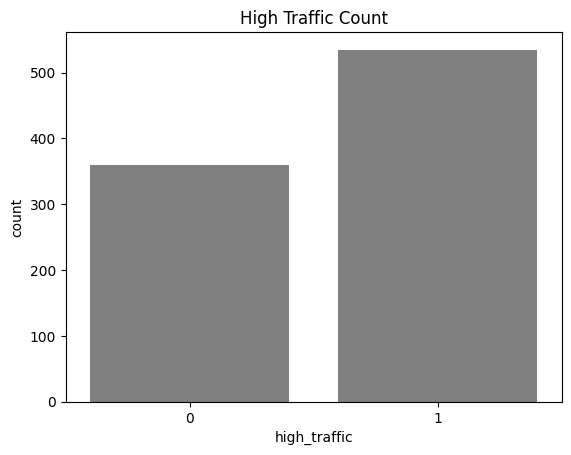

In [51]:
#target varialble
#about 60% of the recipes had high traffic
sns.countplot(data=recipe_df, x='high_traffic', color='grey')
plt.title('High Traffic Count')
plt.show()

The numeric variables are all right skewed with outliers, so I'd need to make sure to standardize the data before passing it to the model thereby preventing the model from being biased.

Text(0.5, 1.0, 'Distribution of Protein')

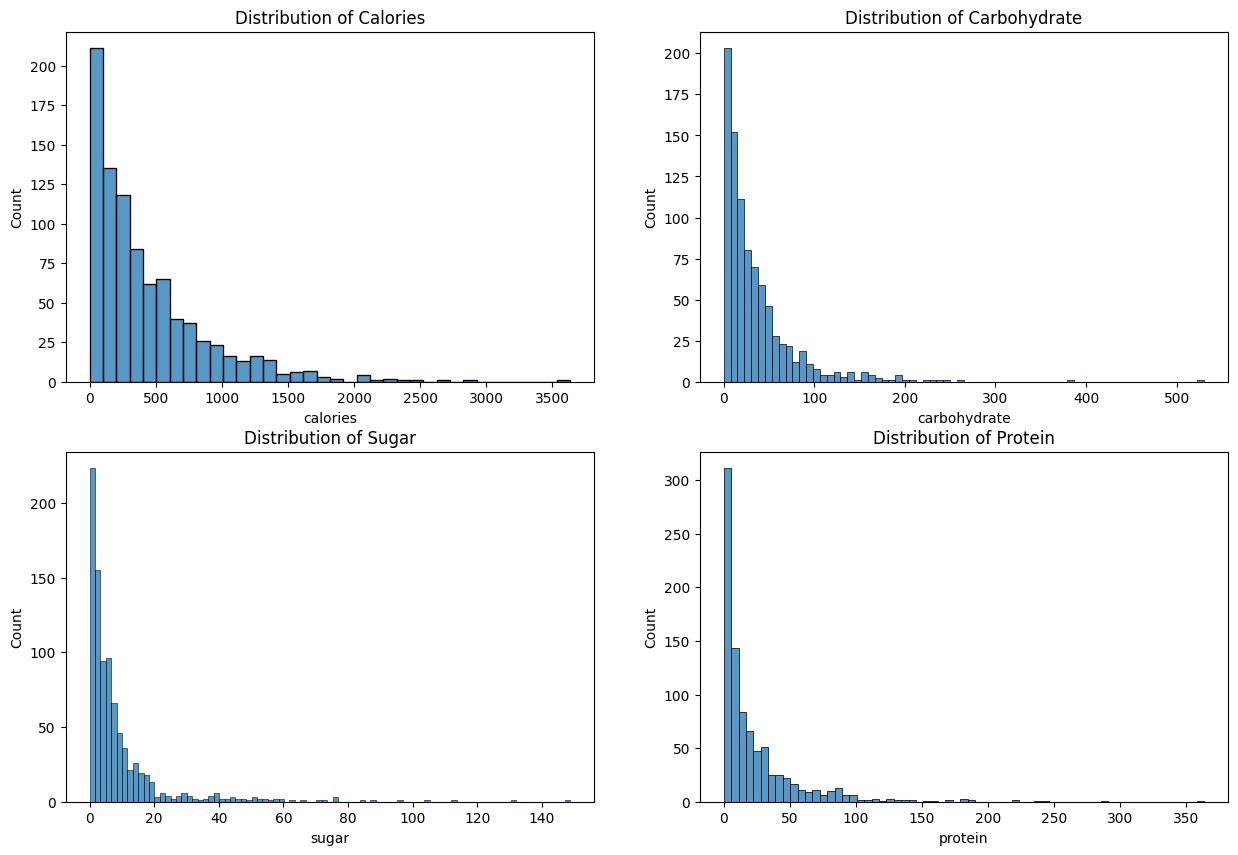

In [52]:
#nutritional value distribution
#no clear conclussion on the relationship with recipe nutritional value and traffic 
# they are all heavily right skewed with outliers
fig, axes = plt.subplots(2,2, figsize=(15,10))
sns.histplot(data=recipe_df, x='calories', ax=axes[0,0]).set_title('Distribution of Calories')
sns.histplot(data=recipe_df, x='carbohydrate', ax=axes[0,1]).set_title('Distribution of Carbohydrate')
sns.histplot(data=recipe_df, x='sugar', ax=axes[1,0]).set_title('Distribution of Sugar')
sns.histplot(data=recipe_df, x='protein', ax=axes[1,1]).set_title('Distribution of Protein')

From the `Recipe Categories` chart, we can see that all recipe categories had a higher proportion as high traffic except for breakfast, beverages and chicken which had the reverse case.

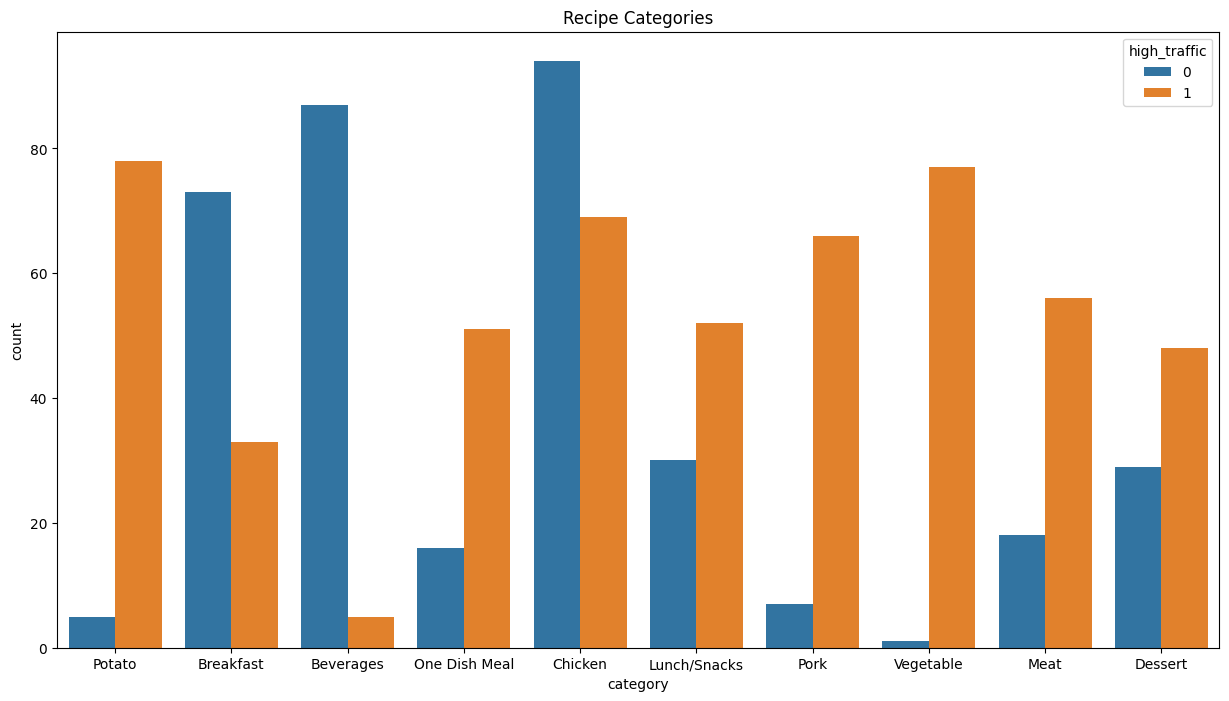

In [53]:
#category
# all recipe categories had a higher proportion as high trffic except for breakfast, beverages and chicken which had the reverse case
plt.figure(figsize=(15, 8))
sns.countplot(data=recipe_df, x='category', hue='high_traffic')
plt.title('Recipe Categories')
plt.show()

Theer is no correlation or linear relationship exists between any of the features and the target variable.

<Figure size 1500x800 with 0 Axes>

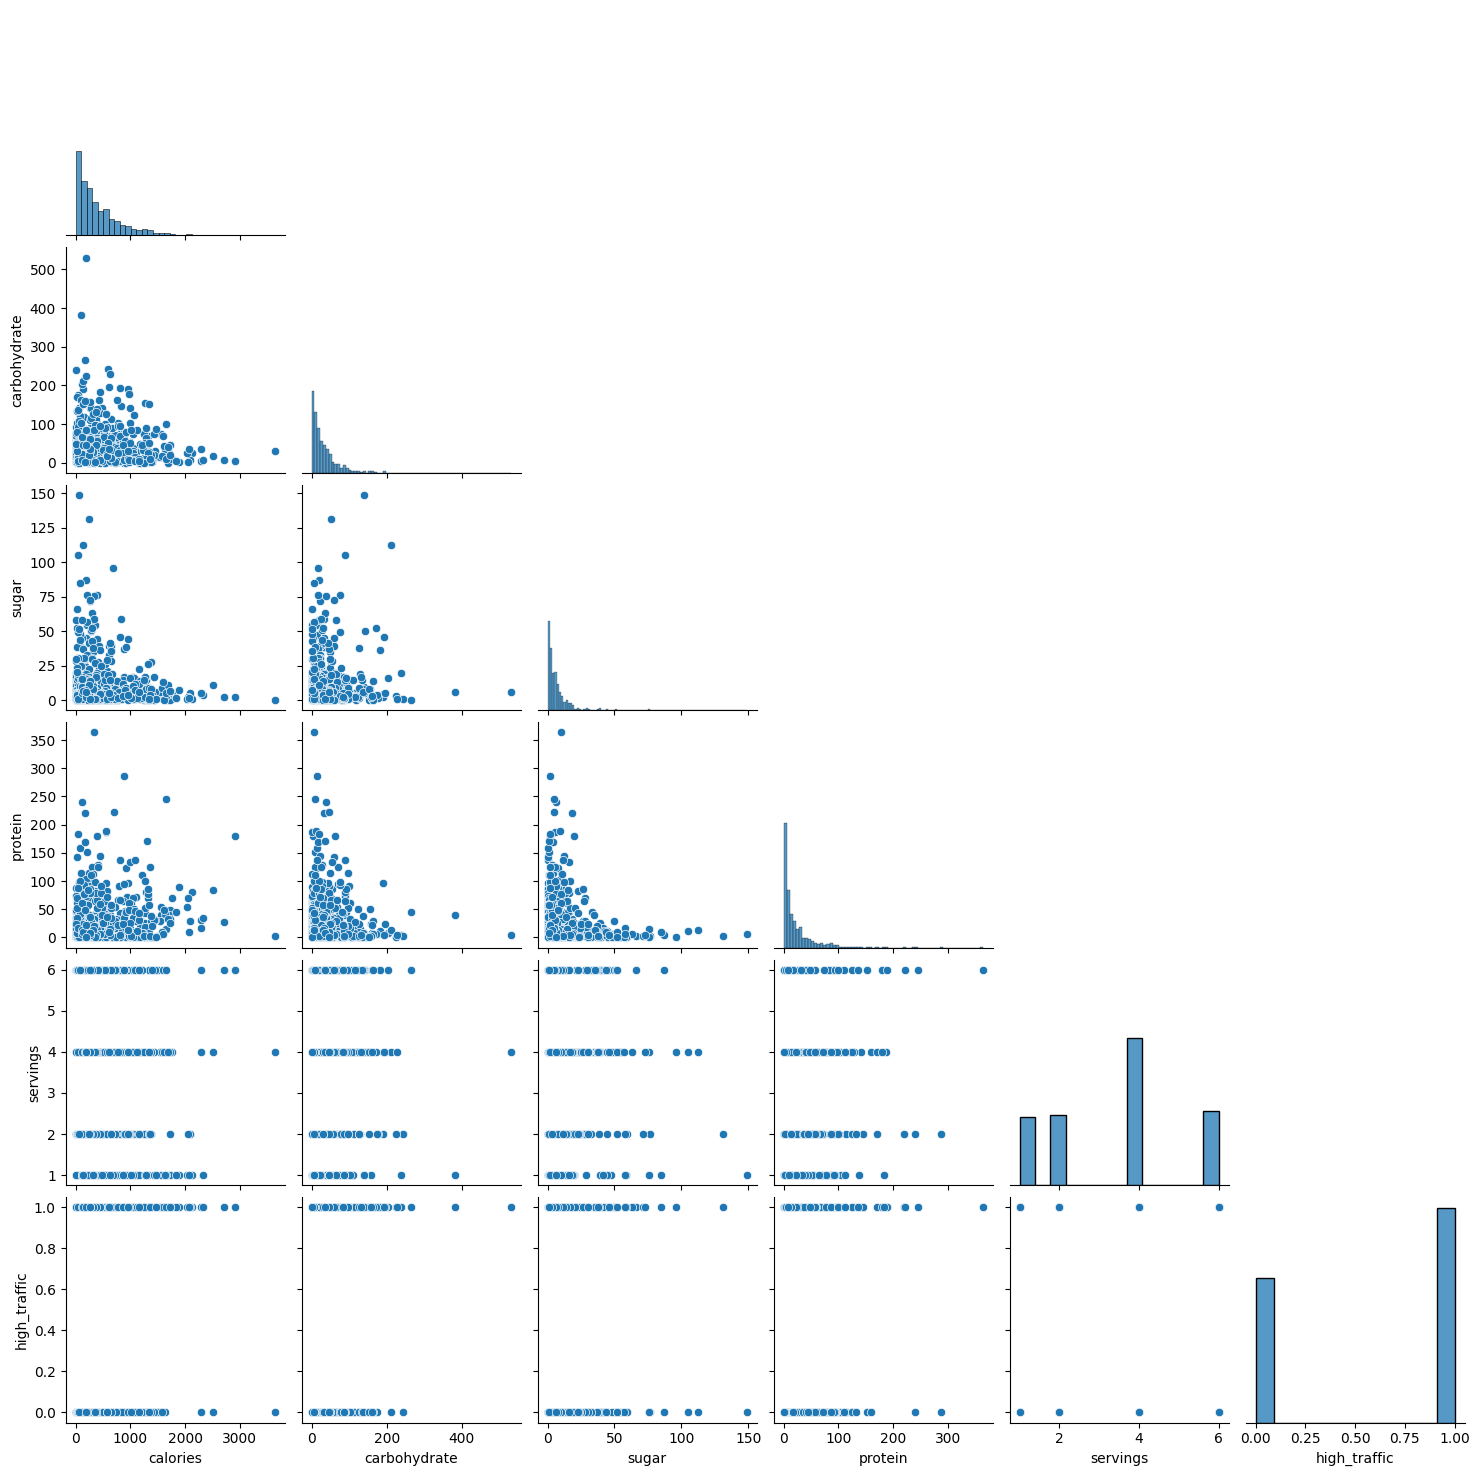

In [54]:
#pairplot
plt.figure(figsize=(15,8))
sns.pairplot(recipe_df.drop(columns=['recipe']), corner=True)
plt.show()

There is a very weak correlation between the nutritional values which is displayed in the heat map.

<AxesSubplot: >

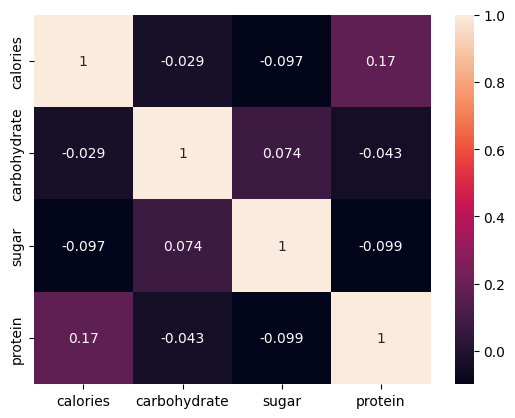

In [55]:
#correlation of numeric columns
#very weak correlation between the nutritional values
numeric = recipe_df[['calories', 'carbohydrate', 'sugar', 'protein']]
sns.heatmap(numeric.corr(), annot=True)

## Model Development

Predicting if a recipe will lead to high traffic on the site is a **classification** problem in machine learning.

I have chosen the Logistic Regression model as the baseline because of its interpretability. The coefficients of the features offer valuable insights into each feature's contribution to the target class, and the model assumes a linear relationship between the features and the target.

I selected Random Forest model as the comparison model because of its strengths in handling imbalanced data. Its ensemble nature and built-in bootstrapping during training make it adept at dealing with imbalanced class distributions. Additionally, the decision tree-based approach allows it to effectively capture non-linear relationships between features and the target.

I am choosing **Precision** as the evaluation metric because **Precision**  focuses on the accuracy of positive predictions. In the context of predicting high-traffic recipes, precision would be the number of correctly predicted high-traffic recipes divided by the total number of recipes predicted as high-traffic (true positives / (true positives + false positives)). Achieving 80% precision would mean that 80% of the recipes predicted as high-traffic are indeed high-traffic.


### Preprocessing the data
Here are the following steps taken to process the data for the model
- I dropped the recipe column because it contains unique values not relevant to the prediction
- Split the data into training and test set
- Converted categorical column to numerical by encoding
- Scale the data to reduce influence of different scales on the model


In [56]:
#drop recipe column
recipe_df.drop(columns='recipe', axis=1, inplace=True)


In [57]:
y = recipe_df['high_traffic'].values
X = recipe_df.drop('high_traffic', axis=1)

#split data before encoding
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [58]:
X_train.head()

,calories,carbohydrate,sugar,protein,category,servings
232,207.37,12.05,22.03,0.38,Beverages,4
515,463.52,5.19,17.61,0.42,Beverages,1
497,350.61,73.29,17.77,1.98,Dessert,4
842,282.89,114.65,2.51,28.11,Lunch/Snacks,6
93,113.84,37.57,1.21,21.31,Chicken,4


In [59]:
#encode categorical column
enc = OneHotEncoder(sparse=False)

X_train_enc = pd.DataFrame(enc.fit_transform(X_train[['category']]), columns=np.array(enc.categories_).ravel(), index = X_train.index)

X_test_enc = pd.DataFrame(enc.transform(X_test[['category']]), columns=np.array(enc.categories_).ravel(), index = X_test.index)


#scale numeric columns
scaler = StandardScaler()
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

X_train_num_sc = pd.DataFrame(scaler.fit_transform(X_train_num), index=X_train_num.index, columns=X_train_num.columns)

X_test_num_sc = pd.DataFrame(scaler.transform(X_test_num), index=X_test_num.index, columns=X_test_num.columns)

#create new dataframes after preprocessing
X_train_new = pd.concat([X_train_num_sc, X_train_enc], axis=1)
X_test_new = pd.concat([X_test_num_sc, X_test_enc], axis=1)


In [60]:
X_train_new

,calories,carbohydrate,sugar,protein,servings,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
232,-0.515732,-0.527745,0.937300,-0.700277,0.305393,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
515,0.057657,-0.682050,0.621188,-0.699043,-1.422100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,-0.195091,0.849752,0.632631,-0.650923,0.305393,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
842,-0.346681,1.780079,-0.458744,0.155090,1.457055,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
93,-0.725097,0.046287,-0.551719,-0.054664,0.305393,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,-0.198270,-0.182921,0.259303,2.307542,0.305393,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36,1.978860,0.777323,-0.083986,-0.110188,-1.422100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.066677,0.161228,-0.417263,-0.623161,-1.422100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,-0.606704,-0.444744,-0.327865,4.525079,0.305393,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Logistic Regression Model

In [61]:
#base line model - Logistic Regression
log_reg = LogisticRegression(random_state=234)
log_reg.fit(X_train_new, y_train)
y_pred = log_reg.predict(X_test_new)

In [62]:
logreg_precision = precision_score(y_test, y_pred) * 100
print(f"Logistic Regression Precision is {np.round(logreg_precision, 2)}%")
print("Logistic Regression Accuracy is:", np.round(accuracy_score(y_test, y_pred) * 100, 2))

Logistic Regression Precision is 77.06%
Logistic Regression Accuracy is: 74.35


## Feature Importance

***Pork, Potato and Vegetable*** recipes are likely to be associated with an increase in the log-odds of the response variable being 1 (success or positive class).
An increase in ***Beverages, Breakfast and Chicken*** variable is associated with a decrease in the log-odds of the response variable being 1.

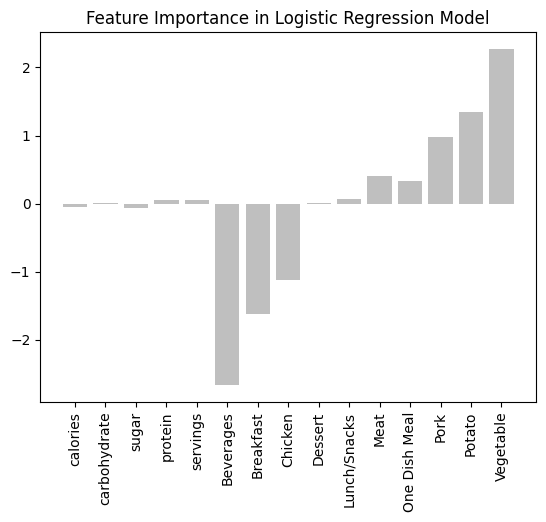

In [63]:
resultdict = {}

feature_cols = X_train_new.columns

for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = log_reg.coef_[0][i]
    
plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5,color='gray')
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Logistic Regression Model');

## Random Forest Model

In [64]:
#fit comparison model - RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=234)
rf_clf.fit(X_train_new, y_train)
rf_y_pred = rf_clf.predict(X_test_new)

In [65]:
rf_precision = precision_score(y_test, rf_y_pred) * 100
print(f"Random Forest Precision is {np.round(rf_precision, 2)}%")
print("Random Forest Accuracy is:", np.round(accuracy_score(y_test, rf_y_pred)*100, 2))

Random Forest Precision is 76.16%
Random Forest Accuracy is: 73.61


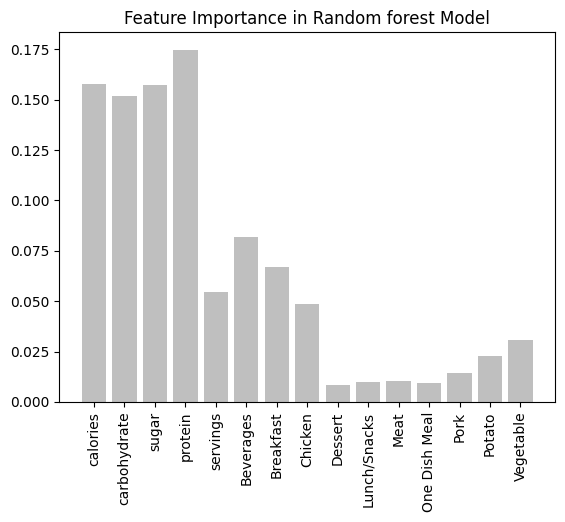

In [66]:
resultdict = {}

feature_cols = X_train_new.columns

for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = rf_clf.feature_importances_[i]
    
plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5,color='gray')
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random forest Model');

### Finding the best parameter for the Random forest model

In [67]:
#Finding the best parameter for the Random forest model

param_grid= {'n_estimators': [100,150,200],
            'criterion': ['gini', 'entropy'],
            'max_depth': list(range(1,10,2)),
            'ccp_alpha': [0.001, 0.01, 0.1]}

grid_clf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='precision')
grid_clf.fit(X_train_new, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=234),
             param_grid={'ccp_alpha': [0.001, 0.01, 0.1],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 150, 200]},
             scoring='precision')

In [68]:
print("Best score",grid_clf.best_score_)
print("Best model params", grid_clf.best_params_)

Best score 0.7700745755533258
Best model params {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 200}


In [69]:
grid_rf_model = grid_clf.best_estimator_
grid_rf_model.fit(X_train_new, y_train)
grid_rf_y_pred = grid_rf_model.predict(X_test_new)

grid_rf_precision = precision_score(y_test, grid_rf_y_pred) * 100
print(f"Random Forest Precision after hyperparameter tuning is {np.round(grid_rf_precision, 2)}%")

Random Forest Precision after hyperparameter tuning is 76.0%


## Results

A high precision value indicates that the model makes fewer false positive predictions, being more cautious in classifying instances as positive. 

The Logistic Regression, and Random Forest model have a precision of 77.06% and 76% respectively. Although he difference in percentage is not much,  the **Logistic Regression model is better at predicting a high traffic recipe**. 



## Evaluate by Business Criteria

The product team wants us to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes. To meet this business criterion, we considered adjusting the prediction probability threshold from 50% to 80%. This adjustment will serve as a key performance indicator (KPI), allowing us to compare the performance of two models: Logistic Regression and Random Forest. The precision of the Logistic Regression model is 97.37%, slightly outperforming the Random Forest model with 96.61%.

Despite the marginal superiority of the Logistic Regression model, the difference is less than 1%. Therefore, the preferred choice is the **Random Forest model** due to its ability to handle non-linear relationships observed in the data.

In [70]:
# Adjust the threshold to 80%
new_threshold = 0.8
y_pred_adjusted = (log_reg.predict_proba(X_test_new)[:, 1] > new_threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("\nAdjusted Threshold Results for Logistic Regression (", new_threshold*100, "):")
print("Accuracy:", np.round(accuracy_score(y_test, y_pred_adjusted) * 100, 2), "%")
print("Precision:", np.round(precision_score(y_test, y_pred_adjusted)*100, 2), "%")




Adjusted Threshold Results for Logistic Regression ( 80.0 ):
Accuracy: 66.91 %
Precision: 97.37 %


In [71]:
# Adjust the threshold to 80%
new_threshold = 0.8
y_pred_adjusted_rf = (grid_rf_model.predict_proba(X_test_new)[:, 1] > new_threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("\nAdjusted Threshold Results for Random Forest(",new_threshold*100,"%):")
print("Accuracy:", np.round(accuracy_score(y_test, y_pred_adjusted_rf) * 100, 2), "%")
print("Precision:", np.round(precision_score(y_test, y_pred_adjusted_rf)*100, 2), "%")


Adjusted Threshold Results for Random Forest( 80.0 %):
Accuracy: 60.59 %
Precision: 96.61 %


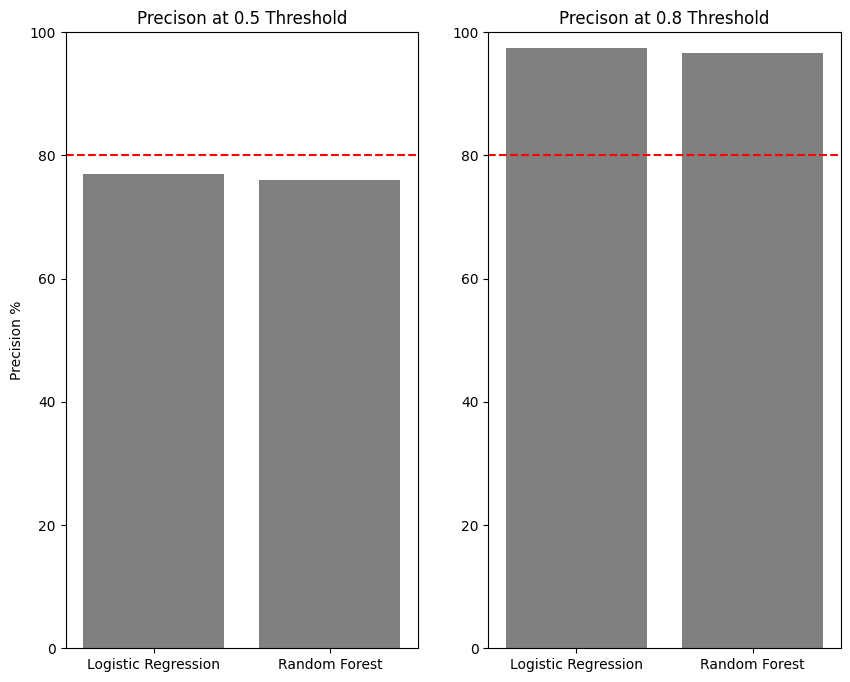

In [72]:
#compare models before and after threshold
logreg_thr_precision = np.round(precision_score(y_test, y_pred_adjusted)*100, 2)
rf_thr_precision = np.round(precision_score(y_test, y_pred_adjusted_rf)*100, 2)

fig, axes = plt.subplots(1,2, figsize=(10,8))
sns.barplot(x=['Logistic Regression', 'Random Forest'], y=[logreg_precision, grid_rf_precision], color='grey', ax=axes[0]).set_ylim(0,100)
axes[0].axhline(y=80, linestyle='--', color='red', label='Threshold')
axes[0].set_title('Precison at 0.5 Threshold')
axes[0].set_ylabel('Precision %')

sns.barplot(x=['Logistic Regression', 'Random Forest'], y=[logreg_thr_precision, rf_thr_precision], color='grey', ax=axes[1]).set_ylim(0, 100)
axes[1].set_title('Precison at 0.8 Threshold')
axes[1].axhline(y=80, linestyle='--', color='red', label='Threshold')
plt.show()

## Recommendation

To assist the Product Manager in determining the popularity of recipes, we can implement the **Random Forest model** in a production environment. With the deployment of this model, an estimated 96% accuracy is anticipated for high-traffic recipe predictions, which is within the 80% correctness rate requested. This deployment will enable the Product Manager to make decisions grounded in data when selecting recipes for the homepage, ultimately boosting subscriptions.

I will recommend the following steps to ensure the model can be deployed and improved regularly:
1. Conduct A/B tests by implementing the model's recommendations in a live environment and assess its performance with newly introduced recipes over an extended duration.

2. Detect and rectify errors to enhance precision based on the findings from the testing phase.

3. Enhance the model's predictive capabilities by collecting and feeding more data into it, addressing the limitations of the small dataset used during the model training.

4. Efficiently deploy the model, either through web integration or utilizing an API, to ensure its full implementation and functionality.

